# Week 5 — Predict2Optimize

This week is about **putting everything together**.

You will run a portfolio *over time* by combining: prediction, optimization, and backtesting.

There is no single correct solution here! Still some pointers are given.

---

## The loop

> predict returns → optimize portfolio → hold → rebalance → repeat

---

## What you need to do (roughly)

1. **Choose assets and dates**  
   Use a small set of tickers and a reasonable time range.

2. **Build a predictor**  
   Estimate $\hat\mu_t, \hat\Sigma_t$ using past returns only.

   Stick to an easy model - linear predictor for returns, and simple rolling covariance estimate for covariance matrix.

3. **Set a baseline**  
   Examples: 1/N portfolio, or GMVP etc.

4. **Reuse your optimizer**  
   Use your Week 4 Markowitz optimizer.

5. **Write a strategy function**  
   Takes time `t`, past returns, previous weights -> returns new weights. See the howto.

6. **Run the backtest**  
   Choose rebalancing frequency and transaction costs.

7. **Plot diagnostics**
    * Net wealth
    * Daily returns
    * Portfolio weights
    * Turnover
    * ... feel free to extend this, perhaps track the free cash as well?

    > Compare against your baseline.

---

## Common pitfalls

* **Look-ahead bias**
* **Too-frequent rebalancing**
* **Overtrusting predictions**
    - assume some simple uncertainty set and use robust optimization!

---

## Bonus ideas (optional)

* Transaction-cost-aware optimizer (see last bonus section in [howto.ipynb](howto.ipynb))
* Weekly vs monthly rebalancing
* Robust Markowitz
* Rolling Sharpe ratio

---

That’s it. Build a portfolio using the tools you wrote (and the helpers :D)!

Optimize away!
---

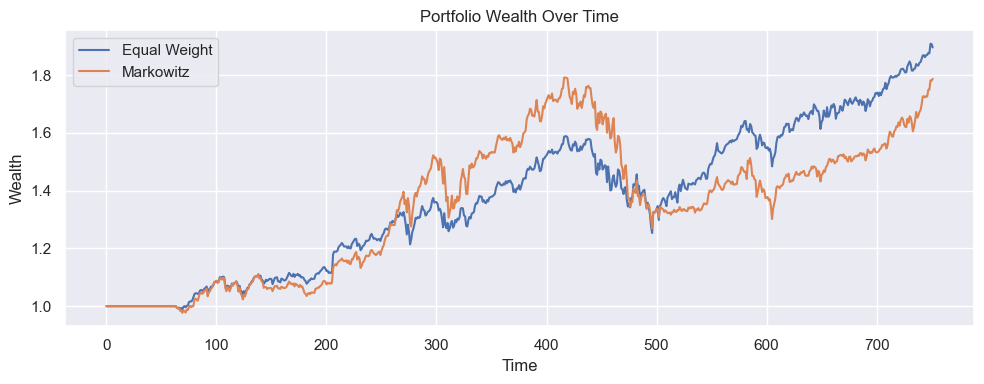

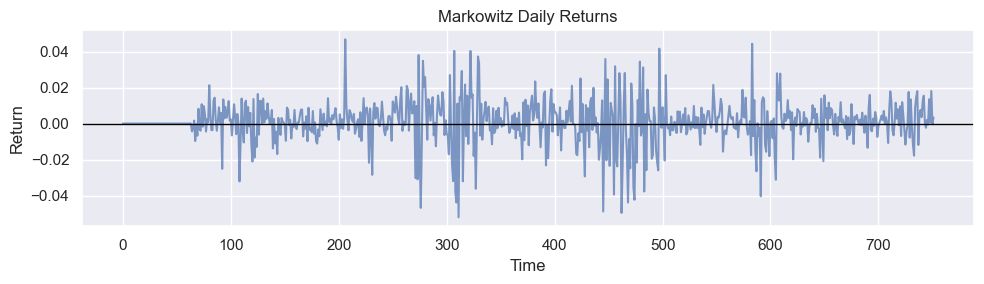

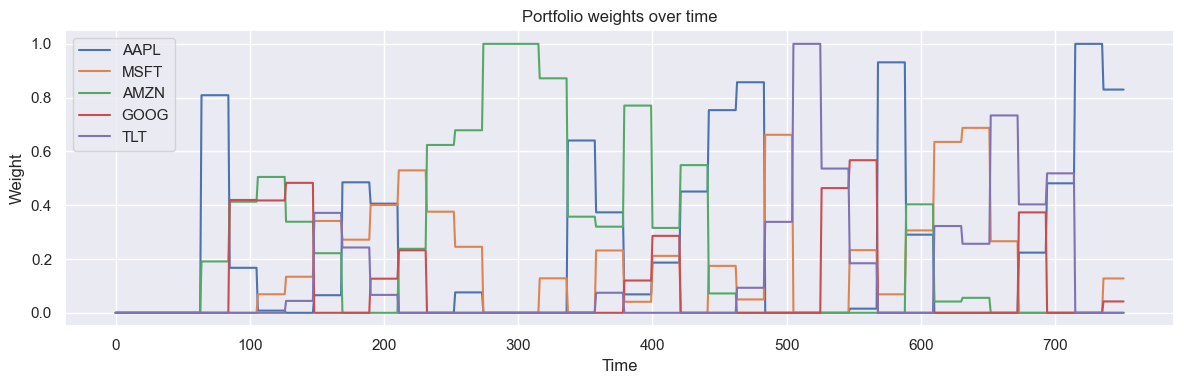

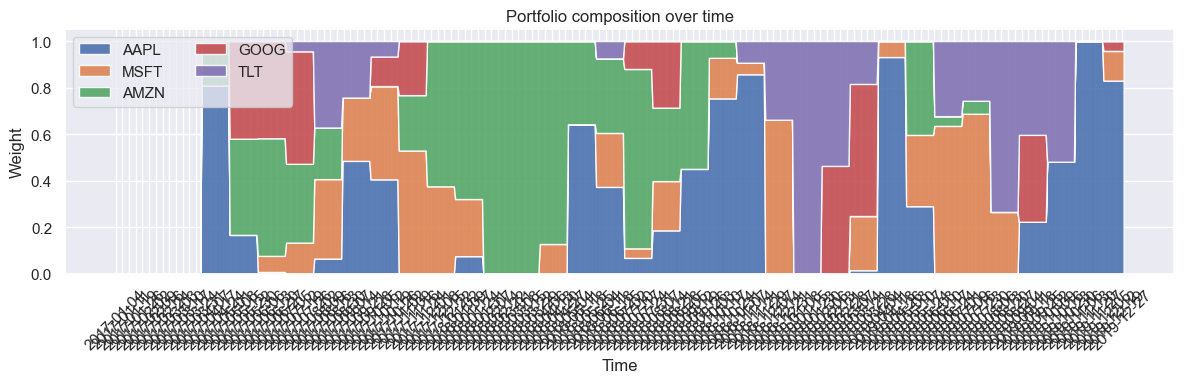

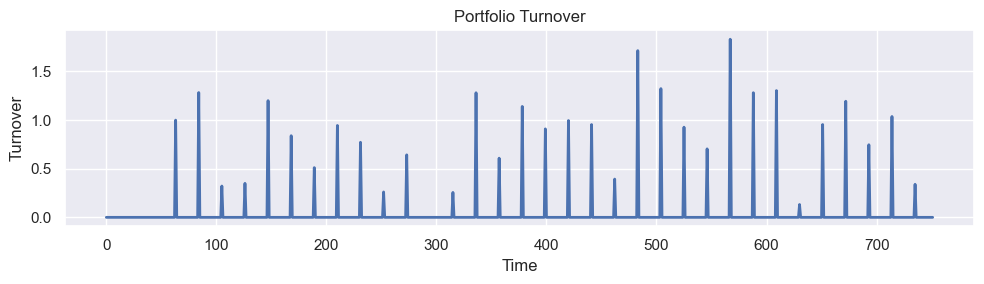

=== Equal Weight ===
Performance summary
-------------------
Total return:     89.62%
Avg daily return: 0.0009
Daily volatility: 0.0103

=== Markowitz ===
Performance summary
-------------------
Total return:     78.73%
Avg daily return: 0.0009
Daily volatility: 0.0122


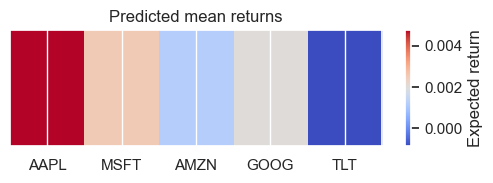

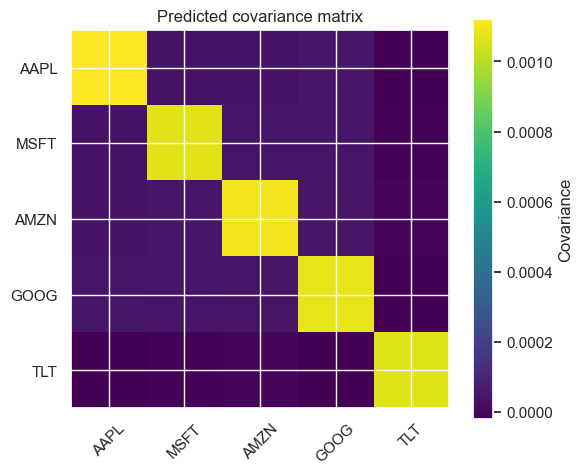

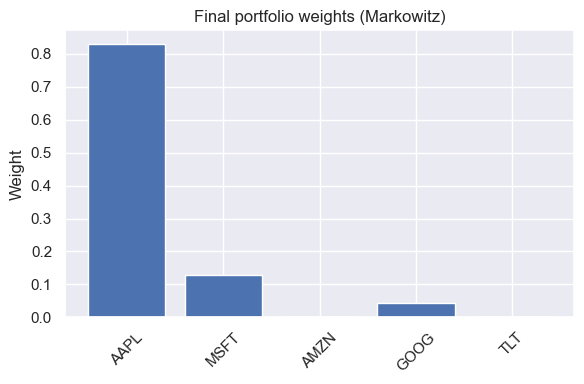

Final portfolio statistics
---------------------------
Expected return : 0.0043
Volatility      : 0.0283
Sharpe ratio    : 0.1534


In [5]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

def backtest_engine(
    asset_returns,
    time_index,
    start_capital,
    allocation_rule,
    warmup=60,
    rebalance_gap=21,
    tc_rate=0.0,
):
    R = np.asarray(asset_returns)
    T, d = R.shape

    nav = np.zeros(T)
    cash_bal = np.zeros(T)
    pnl = np.zeros(T)
    trades = np.zeros(T)
    w_path = np.zeros((T, d))

    nav[: warmup + 1] = start_capital
    cash_bal[: warmup + 1] = start_capital

    current_w = np.zeros(d)

    for t in range(warmup, T - 1):

        fee = 0.0
        if t % rebalance_gap == 0:
            desired_w = allocation_rule(t, R, current_w)

            turnover_amt = np.abs(desired_w - current_w).sum()
            fee = tc_rate * turnover_amt * nav[t]

            current_w = desired_w
            trades[t] = turnover_amt
            cash_bal[t] -= fee

        step_return = current_w @ R[t + 1]
        pnl[t + 1] = step_return

        nav[t + 1] = nav[t] * (1 + step_return) - fee
        cash_bal[t + 1] = cash_bal[t] * (1 + step_return) - fee
        w_path[t + 1] = current_w

    return {
        "wealth": nav,
        "cash": cash_bal,
        "returns": pnl,
        "weights": w_path,
        "turnover": trades,
        "dates": time_index,
    }


def estimate_moments(ret_slice, eps=1e-3):
    mu = ret_slice.mean(axis=0)
    cov = np.cov(ret_slice, rowvar=False)

    cov = (cov + cov.T) / 2
    cov += eps * np.eye(cov.shape[0])
    return mu, cov


def solve_markowitz(mu, cov, risk_penalty=1.0):
    n = mu.shape[0]
    w = cp.Variable(n)

    obj = cp.Maximize(mu @ w - risk_penalty * cp.quad_form(w, cov))
    cons = [cp.sum(w) == 1, w >= 0]

    prob = cp.Problem(obj, cons)

    try:
        prob.solve(solver=cp.OSQP, verbose=False)
    except cp.error.SolverError:
        prob.solve(solver=cp.SCS, verbose=False)

    if w.value is None:
        return None, None, None

    w_star = np.asarray(w.value).flatten()
    return w_star, mu @ w_star, w_star.T @ cov @ w_star


def uniform_weight_rule(t, R, prev_w):
    return np.ones(R.shape[1]) / R.shape[1]


def markowitz_rule(t, R, prev_w, window=60, risk_penalty=1.0):
    hist = R[t - window : t]
    mu_hat, cov_hat = estimate_moments(hist)

    w_opt, _, _ = solve_markowitz(mu_hat, cov_hat, risk_penalty)

    if w_opt is None or np.any(np.isnan(w_opt)):
        if prev_w.sum() <= 0:
            return np.ones(R.shape[1]) / R.shape[1]
        return prev_w

    w_opt = np.clip(w_opt, 0, None)
    return w_opt / w_opt.sum()

tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "TLT"]

returns_df = load_return_data(
    tickers,
    start="2017-01-01",
    end="2019-12-31",
)

R = returns_df.values
dates = returns_df.index.astype(str).tolist()
assets = list(returns_df.columns)

L = 60
rebalance = 21
tc = 0.001
lam = 1.0

res_equal = backtest_engine(
    asset_returns=R,
    time_index=dates,
    start_capital=1.0,
    allocation_rule=lambda t, r, w: uniform_weight_rule(t, r, w),
    warmup=L,
    rebalance_gap=rebalance,
    tc_rate=tc,
)

res_markowitz = backtest_engine(
    asset_returns=R,
    time_index=dates,
    start_capital=1.0,
    allocation_rule=lambda t, r, w: markowitz_rule(
        t, r, w, window=L, risk_penalty=lam
    ),
    warmup=L,
    rebalance_gap=rebalance,
    tc_rate=tc,
)

plt.figure(figsize=(10, 4))
plt.plot(res_equal["wealth"], label="Equal Weight")
plt.plot(res_markowitz["wealth"], label="Markowitz")
plt.title("Portfolio Wealth Over Time")
plt.xlabel("Time")
plt.ylabel("Wealth")
plt.legend()
plt.tight_layout()
plt.show()

plot_returns(res_markowitz["returns"], title="Markowitz Daily Returns")
plot_weights_over_time(res_markowitz["weights"], assets)
plot_weights_stacked_area(res_markowitz["weights"], assets, dates)
plot_turnover(res_markowitz["turnover"])

# ---------------- Stats ---------------- #

print("=== Equal Weight ===")
print_performance_summary(res_equal["wealth"], res_equal["returns"])

print("\n=== Markowitz ===")
print_performance_summary(res_markowitz["wealth"], res_markowitz["returns"])

mu_end, cov_end = estimate_moments(R[-L:])
visualize_single_portfolio(
    mu=mu_end,
    Sigma=cov_end,
    w=res_markowitz["weights"][-1],
    tickers=assets,
    title_suffix=" (Markowitz)",
)